##### Copyright 2020 Google LLC.


Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
import os
import numpy
import seaborn
import pandas
import matplotlib
import matplotlib.style
import matplotlib.patheffects
import matplotlib as mpl
from matplotlib import pyplot as pyplot
from scipy.spatial import distance

from IPython.display import display
from collections import OrderedDict

mpl.style.use('classic')

import random
import tempfile
import zipfile

## Load large dataframe of sequences

In [ ]:
# Version to use with Jupyter (put zip file in the same directory)
my_zip = zipfile.ZipFile('allseqs_20191230.csv.zip')
my_zip.extractall() # extract csv file to the current working directory

df = pandas.read_csv('allseqs_20191230.csv', index_col=None)
df.head(3)

,sequence,partition,mutation_sequence,num_mutations,num_edits,viral_selection,is_viable
0,ADEEIRATNPIATEMYGSVSTNLQLGNR,designed,AD____A___I___M_________L___,6,6,-2.027259,False
1,ADEEIRATNPVATEQYGSVSTNQQRQNR,designed,AD____A_______________Q__Q__,5,5,-0.429554,True
2,ADEEIRTTNPVATEQWGGVSTNLQIGNY,designed,AD_____________W_G______I__Y,6,6,-0.527843,True


## Figure 2: performance by mutation distance line plots

In [ ]:
def get_diversity_threshold_linestyle(num_std_devs, scale):
  num_std_devs = abs(num_std_devs)  # symmetric
  # 0 is equivalent to mu, +1 is mu+sigma, -1 is mu-sigma, etc.
  linestyles = {
      0: (),
      1: (5, 2),
      2: (2, 2, 2, 2),
  }
  if num_std_devs not in linestyles:
    raise ValueError('No linestyle defined for # std devs = %r' % num_std_devs)
  return (0, tuple(x*scale for x in linestyles[num_std_devs]))

def get_diversity_threshold_linewidth(num_std_devs, scale):
  num_std_devs = abs(num_std_devs)
  # 0 is equivalent to mu, +1 is mu+sigma, -1 is mu-sigma, etc.
  linestyles = {
      0: .5,
      1: .5,
      2: .5,
  }
  if num_std_devs not in linestyles:
    raise ValueError('No linestyle defined for # std devs = %r' % num_std_devs)
  return scale*linestyles[num_std_devs]  

def get_diversity_threshold_alpha(num_std_devs):
  num_std_devs = abs(num_std_devs)
  # 0 is equivalent to mu, +1 is mu+sigma, -1 is mu-sigma, etc.
  alpha = .3
  linestyles = {
      0: alpha,
      1: alpha,
      2: alpha,
  }
  if num_std_devs not in linestyles:
    raise ValueError('No linestyle defined for # std devs = %r' % num_std_devs)
  return linestyles[num_std_devs] 


blues_palette = seaborn.color_palette('Blues')
oranges_palette = seaborn.color_palette('Oranges')
purples_palette = seaborn.color_palette('Purples')
greens_palette = seaborn.color_palette('Greens')
DEFAULT_SATURATION_INDEX = -2


def get_arch_color_for_partition(category, saturation_index=DEFAULT_SATURATION_INDEX):
  if category.startswith('lr'):
    color = oranges_palette[saturation_index-1]
  elif category.startswith('cnn'):
    color = blues_palette[saturation_index]
  elif category.startswith('rnn'):
    color = greens_palette[saturation_index]
  elif category == 'designed':
    color = (109/255., 109/255., 109/255.) # gray
  elif category == 'rand':  # FIXME probably pick something better.... Sam used this for ivis plots so using for consistency
    color = 'black'
  else:
    raise ValueError('??: "%s"' % category)
  return color


def get_arch_marker_for_partition(category):
  if category.startswith('lr'):
    marker = 'o' # circle
  elif category.startswith('cnn'):
    marker = 's' # square
  elif category.startswith('rnn'):
    marker = '^' # triangle
  elif category == 'designed':
    marker = None#'D' # diamond
  elif category == 'rand':
    marker = None#'x' # diamond
  else:
    raise ValueError('??: "%s"' % category)
  return marker

seaborn.set_style('white')

legend_labels = {
    'rnn_rand_doubles_plus_singles_seed': 'RNN<random double mutants>',
    'rnn_standard_seed': 'RNN<random multi-mutants>',
    'rnn_designed_plus_rand_train_seed': 'RNN<designed mutants>',
    'cnn_rand_doubles_plus_single_seed': 'CNN<random double mutants>',
    'cnn_standard_seed': 'CNN<random multi-mutants>',
    'cnn_designed_plus_rand_train_seed': 'CNN<designed mutants>',
    'lr_rand_doubles_plus_single_seed': 'LR<random double mutants>',
    'lr_standard_seed': 'LR<random multi-mutants>',
    'lr_designed_plus_rand_train_seed': 'LR<designed mutants>',
    
    'rnn_rand_doubles_plus_singles_walked': 'RNN<random double mutants>',
    'rnn_standard_walked': 'RNN<random multi-mutants>',
    'rnn_designed_plus_rand_train_walked': 'RNN<designed mutants>',
    'cnn_rand_doubles_plus_single_walked': 'CNN<random double mutants>',
    'cnn_standard_walked': 'CNN<random multi-mutants>',
    'cnn_designed_plus_rand_train_walked': 'CNN<designed mutants>',
    'lr_rand_doubles_plus_single_walked': 'Dataset A',
    'lr_standard_walked': 'Dataset B',
    'lr_designed_plus_rand_train_walked': 'Dataset C',     
    
    'designed': 'Additive',
    'rand': 'Random'
}

model_generated_partitions = [
 'rnn_designed_plus_rand_train_walked',
 'rnn_designed_plus_rand_train_seed',
 'rnn_rand_doubles_plus_singles_walked',
 'rnn_rand_doubles_plus_singles_seed',
 'rnn_standard_walked',
 'rnn_standard_seed',
 'cnn_designed_plus_rand_train_walked',
 'cnn_designed_plus_rand_train_seed',
 'cnn_rand_doubles_plus_single_walked',
 'cnn_rand_doubles_plus_single_seed',
 'cnn_standard_walked',
 'cnn_standard_seed',
 'lr_designed_plus_rand_train_walked',
 'lr_designed_plus_rand_train_seed',
 'lr_rand_doubles_plus_single_walked',
 'lr_rand_doubles_plus_single_seed',
 'lr_standard_walked',
 'lr_standard_seed',                              
]

In [ ]:
def viable_frac_by_partitions(
    df, 
    partitions, 
    labels=legend_labels, 
    plot_filepath=None,
    min_mutation_distance=2,
    max_mutation_distance=30,
    extra_mut_thresholds=[],
    allowed_mut_thresholds = [12, 18, 24],
    diversity_mu = 12,
    diversity_sigma = 6,
    dpi=300,
    figsize=(15, 8),
    linewidth=1,
    threshold_linewidth=.25,
    markersize=3,
    scale=4):  

  pyplot.figure(figsize=(15, 8))  
  ax = pyplot.gca()

  if partitions[0].endswith('_seed'):
    mut_thresholds = [m for m in allowed_mut_thresholds if m <= 25]
  elif partitions[0].endswith('_walked'):
    mut_thresholds = [m for m in allowed_mut_thresholds if m <= 29]
  elif partitions[0].endswith('designed'):
    mut_thresholds = [m for m in allowed_mut_thresholds if m <= 29]
  else:
    raise ValueError('unexpected partition name "%s"' % partitions[0])

  partition_to_data = {}
  
  # mut_threshold_start_y = 100  # data coords
  # mut_threshold_delta_y = 7  # data coords
  mut_threshold_delta_y = .1
  mut_threshold_offset_x = -.2
  mut_threshold_start_y = 1 + 2*(mut_threshold_delta_y)
  anno_trans = matplotlib.transforms.blended_transform_factory(
      ax.transData, ax.transAxes)  
  for partition in partitions:
    num_mutations = []
    viable_fracs = []
    num_viables = []
    for mut, group in df[df.partition == partition].groupby('num_edits'):
      if mut < min_mutation_distance:
        continue
      num_mutations.append(mut)
      num_viables.append(group.is_viable.sum())
      if len(group):
        viable_fracs.append(group.is_viable.mean() * 100)
      else:
        viable_fracs.append(0)
    partition_to_data[partition] = pandas.DataFrame({
        'num_mutations': num_mutations,
        'viable_fracs': viable_fracs,
        'num_viables': num_viables,
    })
    seaborn.despine()

  for partition_index, partition in enumerate(partitions):
    series_data = partition_to_data[partition]
    num_mutations = series_data.num_mutations
    num_viables = series_data.num_viables
    viable_fracs = series_data.viable_fracs
    color = get_arch_color_for_partition(partition)
    marker = get_arch_marker_for_partition(partition)
    linestyle = '-'

    pyplot.plot(
      num_mutations, 
      viable_fracs, 
      label=legend_labels[partition], 
      color=color, 
      linestyle=linestyle, 
      linewidth=linewidth*scale,
      marker=marker,
      markersize=markersize*scale,
      markeredgecolor=color,
      markerfacecolor=color,
      )
    
    for mut_threshold in extra_mut_thresholds + mut_thresholds:
      if partition in ('rand', 'designed'):  # don't annotate these
        continue

      if 'seed' in partition: 
        continue # skip most for now

      gte_data = series_data[series_data.num_mutations >= mut_threshold]
      # xycoords_xform = ...
      anno_x = (mut_threshold + mut_threshold_offset_x)
      anno_y = (mut_threshold_start_y - partition_index * mut_threshold_delta_y)

      anno_color = get_arch_color_for_partition(
          partition, saturation_index=-1)
      pyplot.annotate(
          str(gte_data.num_viables.sum()), 
          (anno_x, anno_y),
          xycoords=anno_trans,
          horizontalalignment='right',
          color=anno_color,
          )

  # Draw the absolute values along the x thresholds
  threshold_linestyle = (0, [part*scale for part in (3, 1)])
  line_thresholds = extra_mut_thresholds + mut_thresholds
  for m in line_thresholds:
    num_std_devs = (m - diversity_mu) / diversity_sigma
    if 'seed' in partition:
      threshold_ymax = 1 
    else:
      threshold_ymax = mut_threshold_start_y + mut_threshold_delta_y*.6
    threshold_line = ax.vlines(
        x=m,
        ymax=threshold_ymax,
        ymin=0,
        transform=anno_trans,
        linewidth=get_diversity_threshold_linewidth(num_std_devs, scale), 
        linestyle=get_diversity_threshold_linestyle(num_std_devs, scale),
        color='black',
        alpha=get_diversity_threshold_alpha(num_std_devs))
    # threshold_line.set_clip_on(False)  # allow lines to extend above axis

  pyplot.ylim(0, 105.)
  yticks = [0, 20, 40, 60, 80, 100]
  pyplot.yticks(yticks, ['%d%%' % t for t in yticks])
  pyplot.xlim(min_mutation_distance, max_mutation_distance)
  pyplot.xticks([2, 6, 12, 18, 24, 29])
  ax.tick_params(axis='both')

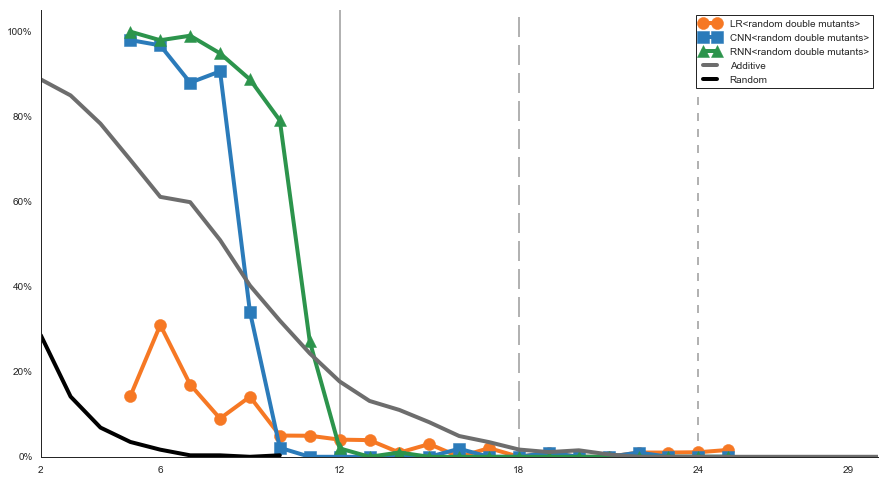

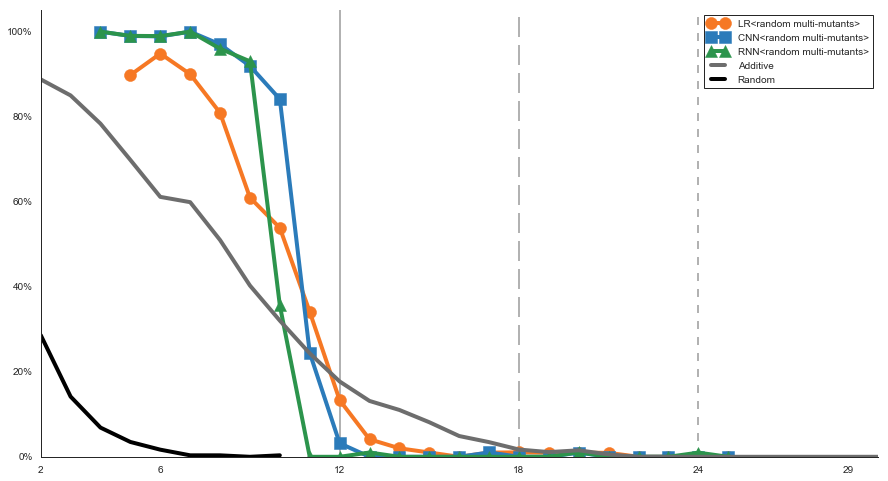

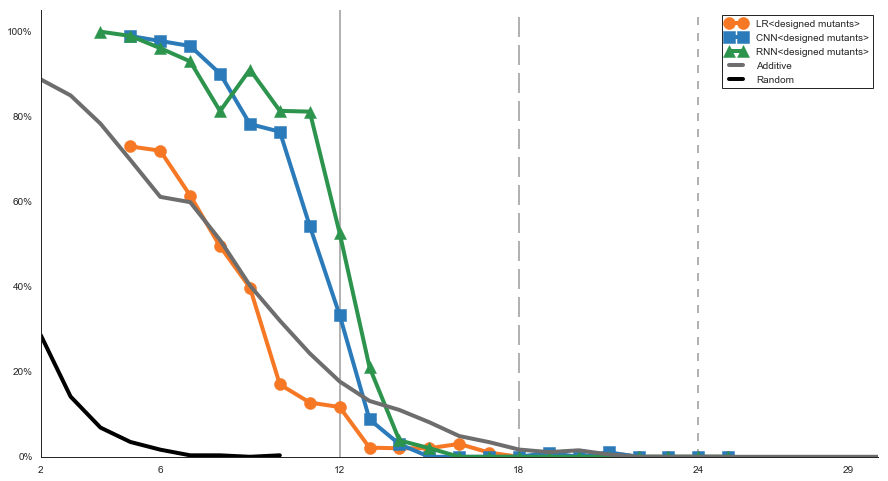

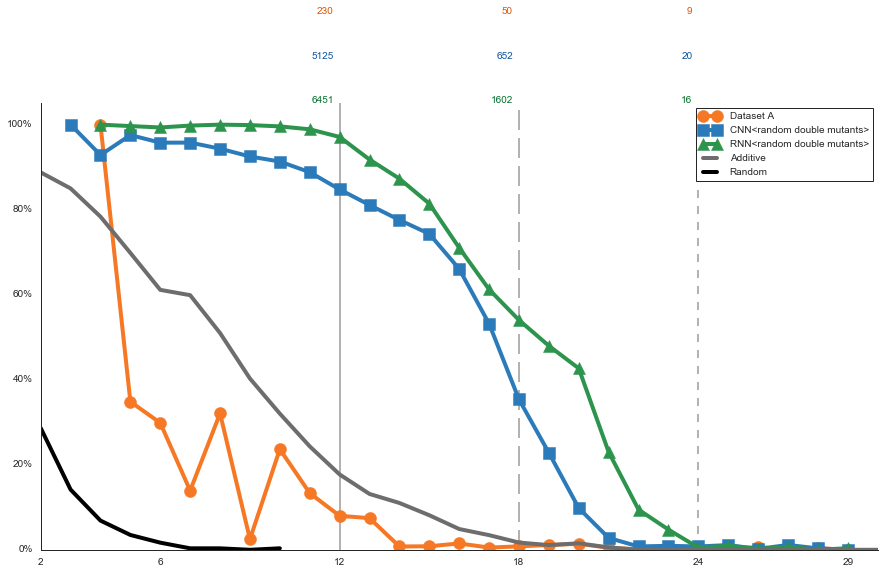

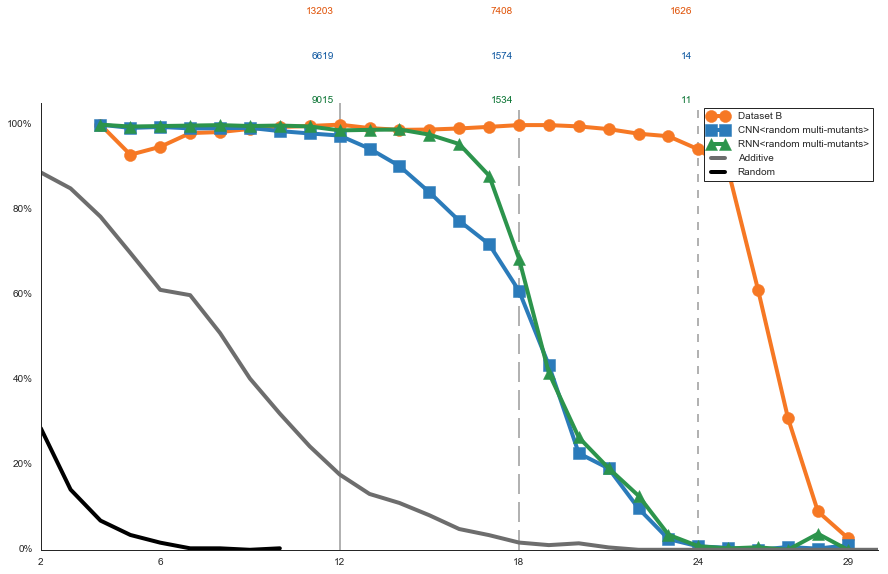

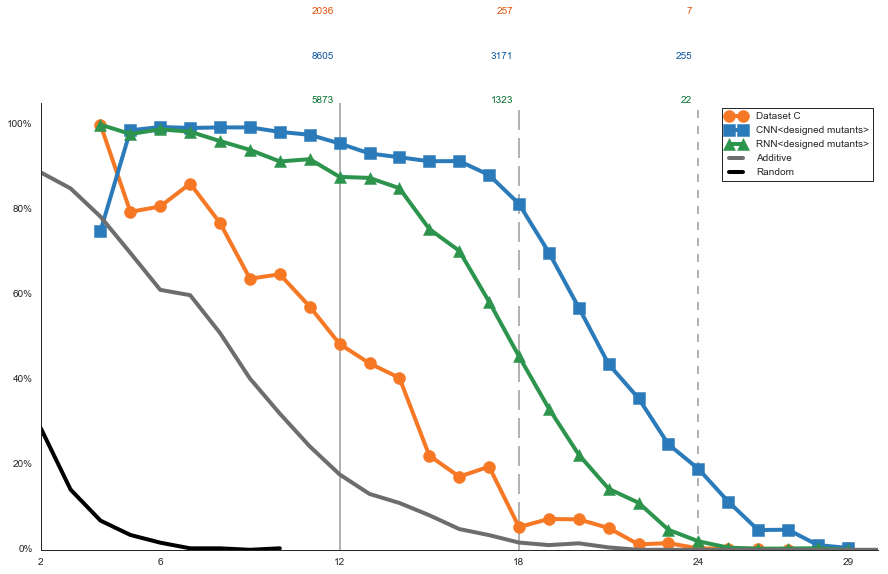

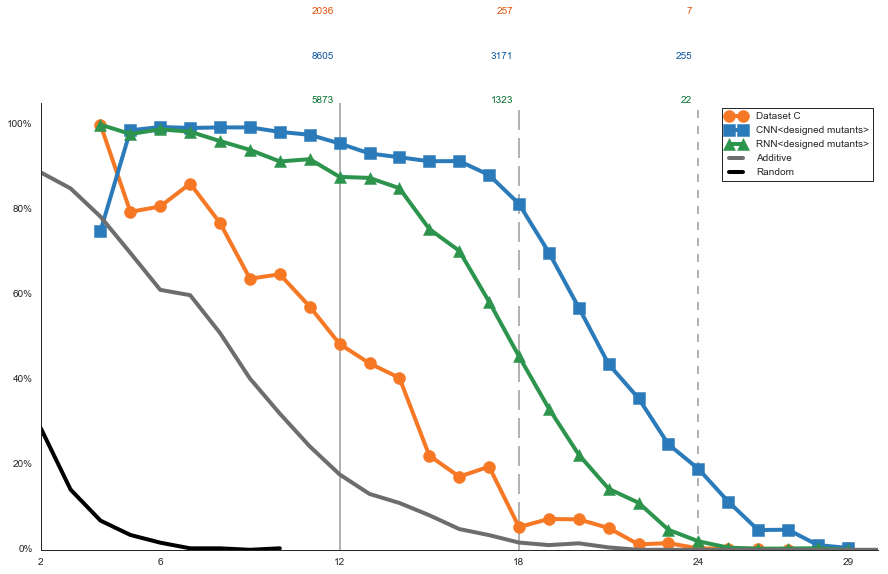

In [ ]:
combined = df.copy()
viable_frac_by_partitions(combined, [
    'lr_rand_doubles_plus_single_seed',
    'cnn_rand_doubles_plus_single_seed',
    'rnn_rand_doubles_plus_singles_seed',
    
    
    'designed',
    'rand',    
  ],
)
pyplot.legend(
    handletextpad=1,
    fontsize=10,
)

viable_frac_by_partitions(combined, [
    'lr_standard_seed',
    'cnn_standard_seed',
    'rnn_standard_seed',
    'designed',
    'rand',    
  ],
)
pyplot.legend(
    handletextpad=1,
    fontsize=10,
)
partition_to_data = viable_frac_by_partitions(combined, [
    'lr_designed_plus_rand_train_seed',
    'cnn_designed_plus_rand_train_seed',    
    'rnn_designed_plus_rand_train_seed',    
    'designed',
    'rand',    
  ],
)
pyplot.legend(
    handletextpad=1,
    fontsize=10,
)

viable_frac_by_partitions(combined, [
    'lr_rand_doubles_plus_single_walked',
    'cnn_rand_doubles_plus_single_walked',
    'rnn_rand_doubles_plus_singles_walked',
    'designed',
    'rand',    
  ],
)
pyplot.legend(
    handletextpad=1,
    fontsize=10,
)
viable_frac_by_partitions(combined, [
    'lr_standard_walked',
    'cnn_standard_walked',
    'rnn_standard_walked',
    'designed',
    'rand',    
  ],
)
pyplot.legend(
    handletextpad=1,
    fontsize=10,
)
viable_frac_by_partitions(combined, [
    'lr_designed_plus_rand_train_walked',
    'cnn_designed_plus_rand_train_walked',
    'rnn_designed_plus_rand_train_walked',
    'designed',
    'rand',    
  ],
)
pyplot.legend(
    handletextpad=1,
    fontsize=10,
)

viable_frac_by_partitions(combined, [
    'lr_designed_plus_rand_train_walked',
    'cnn_designed_plus_rand_train_walked',
    'rnn_designed_plus_rand_train_walked',
    'designed',
    'rand',    
  ],
  scale=4,
  # linewidth=.5,
  # markersize=2,
)
pyplot.legend(
    handletextpad=1,
    fontsize=10,
)